# Evaluation of GRN inference methods
## Processing results
### by Jalil Nourisa



# Imports

In [65]:
%reload_ext autoreload
%autoreload 2
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
import json
from scipy.stats import pearsonr
from pandas.api.types import CategoricalDtype
import seaborn
sys.path.insert(0, '../')
from src.helper import *

plt.rcParams['font.family'] = ' Arial'
default_font = matplotlib.rcParams['font.family']
print(default_font)

task_grn_inference_dir = '../../task_grn_inference'
results_folder = f'{task_grn_inference_dir}/resources/results'
scores_dir = '../../task_grn_inference/resources/scores'
from pandas.api.types import CategoricalDtype
category_order = CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Pearson Corr.', 'Portia', 'PPCOR'], ordered=True)
metrics_category_order = CategoricalDtype(categories=['R1 (all)', 'R1 (grn)', 'R2 (min)', 'R2 (med)', 'R2 (max)'], ordered=True)

datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

%matplotlib inline

['Arial']


In [66]:
# import matplotlib.font_manager as fm

# available_fonts = [f.name for f in fm.fontManager.ttflist]
# available_fonts

# Overview of performance

## Format resourcs used

In [67]:
if False: 
    job_ids_dict = { 
        'portia': 7751292,
        'grnboost2': 7747906,
        'scenic': 7748219,
        'ppcor': 7748321,
        'scglue': [7756286, 7756675],
        'scenicplus': [7761874, 7760439, 7760554],
        'figr': 7756664,
        'celloracle': 7761872,
        'pearson_corr': 7770044,
        'positive_control': 7770047,
        'negative_control':7770048 
    }
    
    df_res = process_trace_local(job_ids_dict)
    df_res = df_res[['Elapsed', 'MaxVMSize']]
    granie = pd.DataFrame({'Elapsed':  3643.337/60/60 * 24, 'MaxVMSize': 41},index=['granie'])
    df_res = pd.concat([df_res, granie], axis=0)
    df_res.columns = ['Duration (hour)', 'Peak memory (GB)']
    df_res.to_csv(f'{task_grn_inference_dir}/resources/results/trace.csv')
else:
    df_res = pd.read_csv(f'{task_grn_inference_dir}/resources/results/trace.csv', index_col=0)


## Merge scores with resources

In [68]:
# - collect all the scores
for i, dataset in enumerate(datasets):
    df_scores = pd.read_csv(f"{task_grn_inference_dir}/resources/scores/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
    # - normalize scores 
    df_scores = df_scores.fillna(0)
    df_scores[df_scores < 0] = 0
    df_scores = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
    df_scores = df_scores.reset_index().melt(id_vars='index', var_name='metric', value_name='r2score').rename(columns={'index':'model'})
    df_scores['dataset'] = dataset
    if i == 0:
        df_all = df_scores
    else:
        df_all = pd.concat([df_all, df_scores], axis=0)
df_all = df_all[~(df_all['model'] == 'collectri')]
# - mean scores for metrics
def mean_for_metrics(df):
    metric = df['metric'].values.flatten()[0]
    if metric in ['S1','S2']:
        df = df[df['dataset']=='op']
    else:
        pass 
    return df[['r2score']].mean()
df_metrics = df_all.groupby(['model','metric']).apply(lambda df: mean_for_metrics(df)).reset_index().pivot(index='model', columns='metric', values='r2score')

# - mean scores for datasets
def mean_for_datasets(df):
    dataset = df['dataset'].values.flatten()[0]
    if dataset != 'op':
        df = df[~df['metric'].isin(['S1','S2'])]
    else:
        pass 
    return df[['r2score']].mean()
df_datasets = df_all.groupby(['model','dataset']).apply(lambda df: mean_for_datasets(df)).reset_index().pivot(index='model', columns='dataset', values='r2score')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/140894904.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics = df_all.groupby(['model','metric']).apply(lambda df: mean_for_metrics(df)).reset_index().pivot(index='model', columns='metric', values='r2score')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/140894904.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning

## Calculate overal scores

In [96]:
# - calculate over scores
df_scores = pd.concat([df_metrics, df_datasets], axis=1)
# df_scores = df_metrics
df_scores['overall_score'] = df_scores.mean(axis=1)

# - merge scores with resources 
df_summary = pd.concat([df_scores, df_res], axis=1)
df_summary = df_summary.fillna(0)
df_summary.index.name = 'method_name' 
df_summary = df_summary.reset_index()

df_summary = df_summary.sort_values(by='overall_score', ascending=False) 

df_summary.method_name = df_summary.method_name.map(surragate_names)
# - add user complexity 
df_summary['User-friendly'] = df_summary['method_name'].map({
                            'Scenic+': 1, 
                            'GRNBoost2': 8, 
                            'Positive Control': 10, 
                            'Baseline Correlation': 10,
                            'CellOracle': 6,
                            'Portia': 9,
                            'scGLUE': 6,
                            'Scenic': 7,
                            'FigR': 6,
                            'PPCOR': 7,
                            'Negative Control': 10,
                            'GRaNIE': 6,
                            })
df_summary['Complexity'] = df_summary['User-friendly'].max() - df_summary['User-friendly']
df_summary.columns = [surragate_names.get(col, col) for col in df_summary.columns]

df_summary= df_summary.fillna(0)
df_summary

,method_name,R1 (all),R1 (grn),R2 (min),R2 (med),R2 (max),Adamson,Nakatake,Norman,OPSCA,Replogle,overall_score,Duration (hour),Peak memory (GB),User-friendly,Complexity
3,GRNBoost2,1.000000,0.776475,0.826432,0.980936,1.000000,1.000000,0.787585,0.941155,0.925419,1.000000,0.923800,150.211111,7.378796,8.0,1.0
7,Positive Con.,0.981252,1.000000,0.958346,0.860857,0.633513,0.832683,0.857764,0.886458,0.865377,0.729077,0.860533,0.300000,11.601669,0.0,0.0
10,Scenic+,0.800199,0.634004,0.913697,0.983595,0.888349,0.000000,0.000000,0.000000,0.843969,0.000000,0.843969,234.811111,131.342854,1.0,8.0
5,Pearson Corr.,0.775394,0.881858,0.880661,0.792117,0.556792,0.814796,0.729421,0.834992,0.718003,0.692485,0.767652,0.827778,23.801899,0.0,0.0
0,CellOracle,0.633710,0.641349,0.843619,0.773048,0.561766,0.000000,0.000000,0.000000,0.690699,0.000000,0.690699,75.300000,41.601166,6.0,3.0
6,Portia,0.632905,0.567038,0.523610,0.337081,0.235700,0.000000,0.511919,0.266277,0.527488,0.569957,0.417198,49.822222,55.685230,9.0,0.0
11,scGLUE,0.211603,0.571086,0.682864,0.316799,0.229125,0.000000,0.000000,0.000000,0.402295,0.000000,0.402295,221.950000,61.677879,6.0,3.0
9,Scenic,0.433522,0.392839,0.437852,0.350487,0.345024,0.000000,0.289197,0.240945,0.606671,0.245343,0.371320,480.172222,35.954300,7.0,2.0
1,FigR,0.305938,0.449542,0.252149,0.345278,0.265239,0.000000,0.000000,0.000000,0.323629,0.000000,0.323629,134.633333,225.208725,6.0,3.0
8,PPCOR,0.267408,0.200610,0.360093,0.285175,0.165767,0.566048,0.041881,0.418685,0.268351,0.033865,0.260788,268.516667,64.136433,7.0,2.0


## Summary figure

In [97]:
summary_file = f"{results_folder}/summary.tsv"
summary_figure = f"{results_folder}/summary_figure"

df_summary['memory_log'] = np.log(df_summary['Peak memory (GB)']+1)
df_summary['memory_log'] = np.max(df_summary['memory_log'])-df_summary['memory_log']

df_summary['complexity_log'] = np.log(df_summary['Complexity']+1)
df_summary['complexity_log'] = np.max(df_summary['complexity_log'])-df_summary['complexity_log']

df_summary["duration_log"] = np.log(df_summary['Duration (hour)']+1)
df_summary['duration_log'] = np.max(df_summary['duration_log'])-df_summary['duration_log']

df_summary["duration_str"] = df_summary['Duration (hour)'].round(1).astype(str)
df_summary['memory_str'] =  df_summary['Peak memory (GB)'].round(1).astype(str)

df_summary.to_csv(summary_file, sep='\t')

!Rscript ../src/summary_figure.R {summary_file} {summary_figure}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warnmeldung:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 12 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (21): ...1, R1 (all), R1 (grn), R2 (min), R2 (med), R2 (max), Adamson, N...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types 

# Scores: datasets

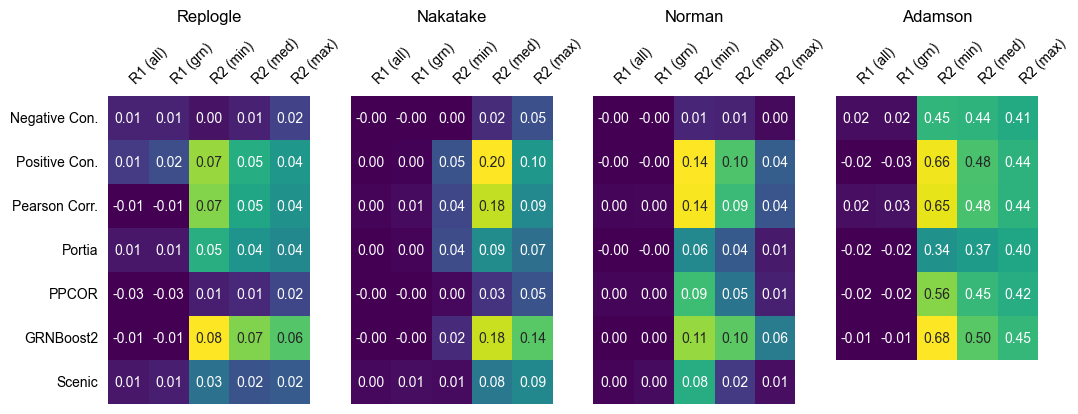

In [71]:
# - raw scores for all datasets - ridge
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
for i, dataset in enumerate(datasets[1:]):
    scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)

    if 'scenic' not in scores_mat.index:
        scores_mat.loc['scenic',:] = np.nan
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)

    ax = axes[i]
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_title(f'{surragate_names[dataset]}', pad=10, fontsize=12)

    
# fig.suptitle(f'Evaluation scores', y=1.1, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/figs/evaluation_scores_other_datasets.png", dpi=300, transparent=True, bbox_inches='tight')

# Scores: opsca, regression types, skelton

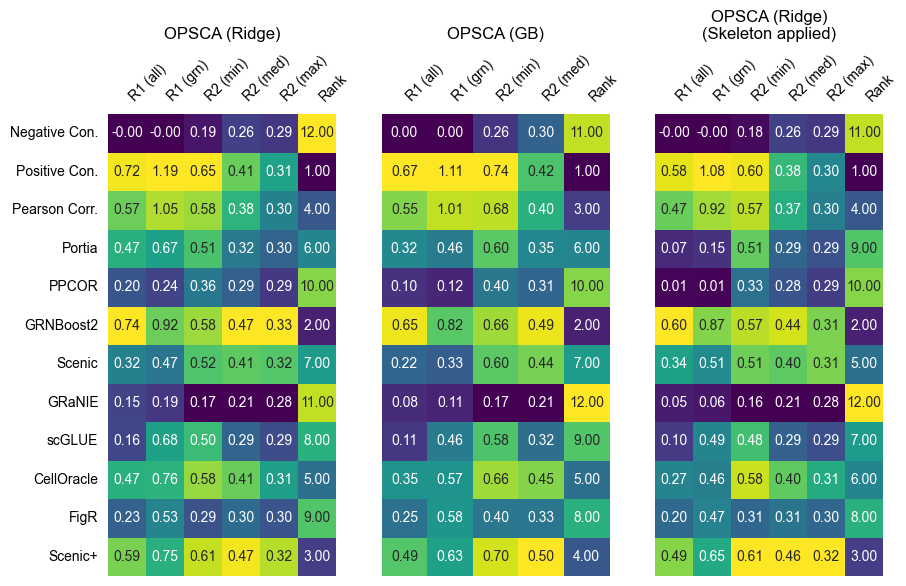

In [72]:
def plot_heatmap(scores, ax=None, name='', fmt='0.02f', cmap="viridis"):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)

    # Normalize each column individually
    scores_normalized = scores.apply(lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), axis=0)

    # Define the color scale range for each column (0 to 1 after normalization)
    vmin = 0
    vmax = 1

    # Plot the heatmap with normalized scores
    seaborn.heatmap(scores_normalized, ax=ax, square=False, cbar=False, annot=True, fmt=fmt, vmin=vmin, vmax=vmax, cmap=cmap)
    # Overlay the original (unnormalized) scores as annotations
    for text, value in zip(ax.texts, scores.values.flatten()):
        text.set_text(f'{value:.2f}')  # Formatting the annotation text to show the unnormalized value

    # Customize the axes and title
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
    
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
dataset = 'op'
for i, reg_type in enumerate(['ridge', 'GB']):
    scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-{reg_type}-global-False.csv', index_col=0)
    if 'collectri' in scores_mat.index:
        scores_mat = scores_mat.drop('collectri')
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(surragate_names)
    scores_rank = scores_mat.div(scores_mat.max(axis=0), axis=1).sum(axis=1)
    scores_mat['Rank'] = scores_rank.rank(ascending=False)

    ax = axes[i]
    plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
    ax.set_title(f"{surragate_names[dataset]} ({reg_type.capitalize() if not reg_type.isupper() else reg_type})", pad=10, fontsize=12)

# scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_False-ridge-global-False.csv', index_col=0)
# scores_mat.columns = scores_mat.columns.map(surragate_names)
# scores_mat.index = scores_mat.index.map(surragate_names)
# scores_rank = scores_mat.div(scores_mat.max(axis=0), axis=1).sum(axis=1)
# scores_mat['Rank'] = scores_rank.rank(ascending=False)

# ax = axes[2]
# plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]} (Ridge)\n(Not binarized)", pad=10, fontsize=12, fontweight='bold')

scores_mat_skeleton = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_True-binarize_False-ridge-global-False.csv', index_col=0)
scores_mat_skeleton.columns = scores_mat_skeleton.columns.map(surragate_names)
scores_mat_skeleton.index = scores_mat_skeleton.index.map(surragate_names)

scores_rank = scores_mat_skeleton.div(scores_mat_skeleton.max(axis=0), axis=1).sum(axis=1)
scores_mat_skeleton['Rank'] = scores_rank.rank(ascending=False)

ax = axes[2]
plot_heatmap(scores_mat_skeleton, name='SLA normalization', ax=ax, cmap="viridis")
ax.set_title(f"{surragate_names[dataset]} (Ridge)\n(Skeleton applied)", pad=10, fontsize=12)
# fig.suptitle('(A) Regression scores (ridge)', y=1.2, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/figs/evaluation_scores_opsca.png", dpi=300, transparent=True, bbox_inches='tight')

In [73]:
category_order

CategoricalDtype(categories=['GRNBoost2', 'Scenic+', 'Pearson Corr.', 'Portia', 'PPCOR'], ordered=True, categories_dtype=object)

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/2638085124.py:19: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/2638085124.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


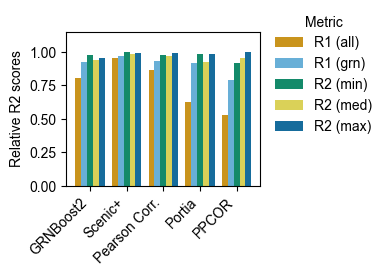

In [74]:
# - skeleton vs normal
scores_mat_ridge = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
# scores_mat_GB = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-GB-global-False.csv', index_col=0)
scores_mat_skeleton = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_True-binarize_True-ridge-global-False.csv', index_col=0)

scores_mat_skeleton_n = scores_mat_skeleton/scores_mat_ridge
scores_mat_skeleton_n = scores_mat_skeleton_n.drop(['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
def plot_skeleton_vs_nonskeleton(ax):
    scores_mat_n_all_long = scores_mat_skeleton_n.reset_index().melt(id_vars='index')
    
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)
    

    scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surragate_names)

    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    # print(scores_mat_n_all_long)
    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative R2 scores')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_skeleton_vs_nonskeleton(ax)
fig.savefig(f"{results_folder}/figs/skelton_guided_barplot.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/29064988.py:14: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/29064988.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


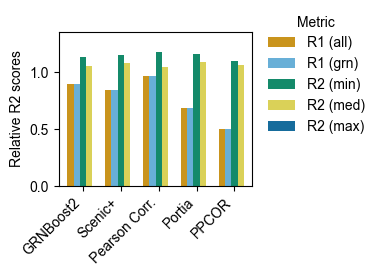

In [75]:
# - GB vs ridge
scores_mat_ridge = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
scores_mat_GB = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-GB-global-False.csv', index_col=0)

scores_mat_n = scores_mat_GB/scores_mat_ridge
scores_mat_n = scores_mat_n.drop(['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
def plot_gb_vs_ridge(ax):
    scores_mat_n_all_long = scores_mat_n.reset_index().melt(id_vars='index')
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)
    scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surragate_names)

    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative R2 scores')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_gb_vs_ridge(ax)
fig.savefig(f"{results_folder}/figs/gb_vs_ridge.png", dpi=300, transparent=True, bbox_inches='tight')

# Scores: global models

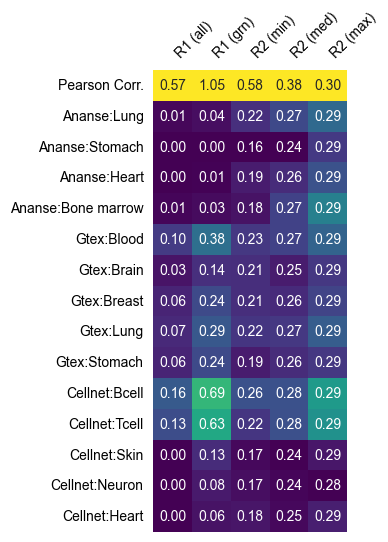

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(2.5, 6), sharey=False)
dataset='op'
ax = axes
scores_mat_o = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
scores_mat = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv', index_col=0)
scores_mat = pd.concat([scores_mat_o.loc[['pearson_corr']], scores_mat])
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(lambda name: surragate_names.get(name,name))


plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]}\n(Global models)", pad=10, fontsize=12, fontweight='bold')
fig.savefig(f"{results_folder}/figs/evaluation_scores_global_models.png", dpi=300, transparent=True, bbox_inches='tight')

# Scores: pseduobulking

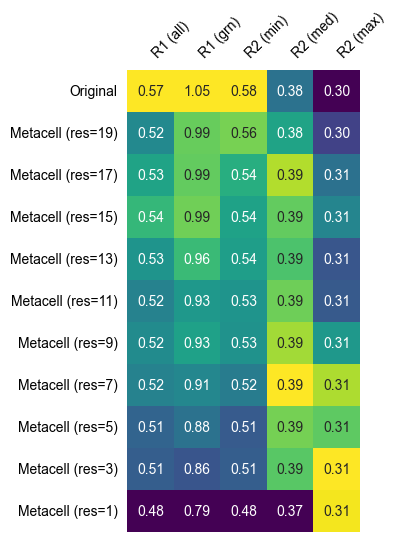

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6), sharey=False)

scores_mat = pd.read_csv(f'{results_folder}/metacells/scores_all.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat.index = scores_mat.index.map(lambda name: 'Original' if name == -1 else f'Metacell (res={name})')

index_oder = ['Original'] + [f'Metacell (res={name})' for name in range(19, 0, -2)]

scores_mat = scores_mat.reindex(index=index_oder)
plot_heatmap(scores_mat, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]}\n(Effect of pseudobulking)", pad=10, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3360922109.py:21: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_melted, x='index', y='Normalized Score', hue='Method', marker='o', ax=ax, palette=colors_blind)


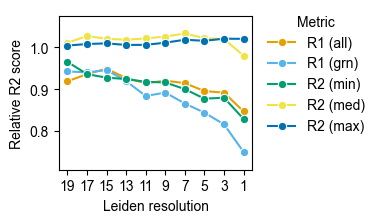

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_line_pseudobulking_effect(ax):
    scores_mat = pd.read_csv(f'{results_folder}/metacells/scores_all.csv', index_col=0)
    scores_mat.columns = scores_mat.columns.map(surragate_names)
    scores_mat.index = scores_mat.index.map(lambda name: 'Original' if name == -1 else f'{name}')

    index_oder = ['Original'] + [f'{name}' for name in range(19, 0, -2)]

    scores_mat = scores_mat.reindex(index=index_oder)
    df_melted = scores_mat.reset_index().melt(id_vars='index', var_name='Method', value_name='Score')

    # Normalize the scores (divide by original for each metric)
    df_melted['Normalized Score'] = df_melted.groupby('Method')['Score'].transform(lambda x: x / x.iloc[0])

    # Remove the "Original" entry to only show the normalized scores
    df_melted = df_melted[df_melted['index'] != 'Original']

    # Plotting
    sns.lineplot(data=df_melted, x='index', y='Normalized Score', hue='Method', marker='o', ax=ax, palette=colors_blind)

    # Customize the plot
    ax.set_ylabel('Relative R2 score')
    ax.set_xlabel('Leiden resolution')
    
    # Rotate the x-axis labels
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

    # Remove top and right spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)

    # Adjust legend position
    ax.margins(y=0.15)
    ax.legend(title='Metric', loc=(1.05, .2), frameon=False)

# Example usage
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_line_pseudobulking_effect(ax)
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation_lineplot.png", dpi=300, transparent=True, bbox_inches='tight')
# plt.tight_layout()
plt.show()

# Scores: imputations

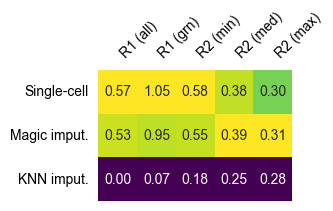

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.7), sharey=False)

scores_mat_o = pd.read_csv(f'{scores_dir}/{dataset}/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv', index_col=0)
scores_mat = pd.read_csv(f'{results_folder}/imputation/scores_all.csv', index_col=0)
df_combined = pd.concat([ scores_mat_o.loc[['pearson_corr']], scores_mat.loc[['magic','knn']]], axis=0)
df_combined.index = ['Single-cell', 'Magic imput.','KNN imput.']
df_combined.columns = df_combined.columns.map(surragate_names)

plot_heatmap(df_combined, name='', ax=ax, cmap="viridis")
# ax.set_title(f"{surragate_names[dataset]}\n(Effect of imputation)", pad=10, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/evaluation_scores_imputation.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/4285641663.py:17: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/4285641663.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


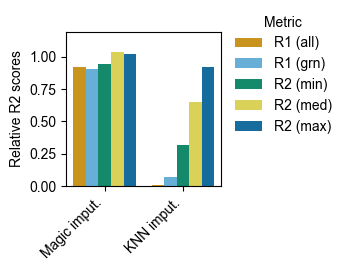

In [80]:
# Select the 'Single-cell' row for normalization
single_cell_row = df_combined.loc['Single-cell']




def plot_imput_vs_singlecell(ax):
    # Normalize all rows by dividing them by the 'Single-cell' row
    normalized_df = df_combined.div(single_cell_row, axis=1)
    normalized_df.drop('Single-cell', inplace=True)
    scores_mat_n_all_long = normalized_df.reset_index().melt(id_vars='index')
    # scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)
    # scores_mat_n_all_long['variable'] = scores_mat_n_all_long['variable'].map(surragate_names)

    # scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].astype(category_order)
    # scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative R2 scores')
    # ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2, 2), sharey=False)
plot_imput_vs_singlecell(ax)
# fig.savefig(f"{results_folder}/figs/imput_vs_singlecell.png", dpi=300, transparent=True, bbox_inches='tight')

# TF-guided inference

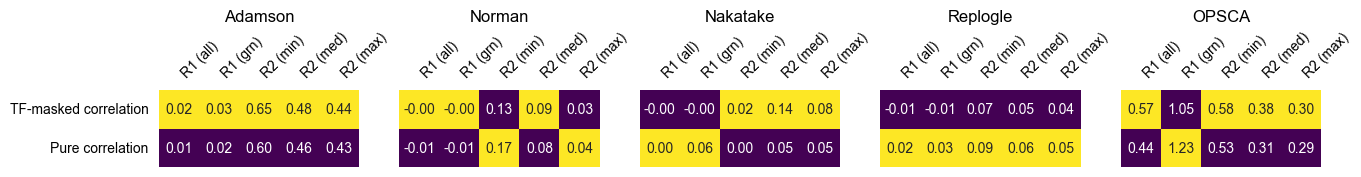

In [81]:
fig, axes = plt.subplots(1, 5, figsize=(15, 1), sharey=True)

scores_mat = pd.read_csv(f'{results_folder}/causal_vs_corr/scores_all.csv', index_col=0)
scores_mat.columns = scores_mat.columns.map(lambda name: surragate_names.get(name,name))
scores_mat['type'] = scores_mat['type'].map(lambda name: {'causal':'TF-masked correlation', 'corr':'Pure correlation'}.get(name,name))


# 
for i, dataset in enumerate(scores_mat.dataset.unique()):
    ax = axes[i]
    scores_mat_sub = scores_mat[scores_mat.dataset==dataset].drop(columns='dataset')
    scores_mat_sub = scores_mat_sub.set_index(['type'])

    scores_mat_sub_n = scores_mat_sub.loc['TF-masked correlation'].div(scores_mat_sub.loc['Pure correlation'], axis=0).to_frame().T
    scores_mat_sub_n.index=[dataset]

    if dataset!='op':
        scores_mat_sub_n = scores_mat_sub_n[['R2 (min)', 'R2 (med)', 'R2 (max)']]

    if i == 0:
        scores_mat_n_all = scores_mat_sub_n
    else:
        scores_mat_n_all = pd.concat([scores_mat_n_all, scores_mat_sub_n]) 

    plot_heatmap(scores_mat_sub, name='', ax=ax, cmap="viridis")
    ax.set_title(surragate_names.get(dataset,dataset))
    # ax.tick_params(axis='y', rotation=0)  # Set x-axis labels horizontal
    ax.set_ylabel('')  # Remove x-axis label
    # if i == 0:
    #     ax.xaxis.tick_top()  # Show x-axis ticks at the top for the first plot
    #     # ax.tick_params(axis='x', rotation=0)  # Set x-axis labels horizontal
    # else:
    #     ax.set_xticks([])
# plt.tight_layout()
# plt.suptitle(f"Metrics performance ", y=1.1, fontsize=12, fontweight='bold')
# fig.savefig(f"{results_folder}/figs/tf_guided_inference.png", dpi=300, transparent=True, bbox_inches='tight')

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/1448742271.py:6: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/1448742271.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


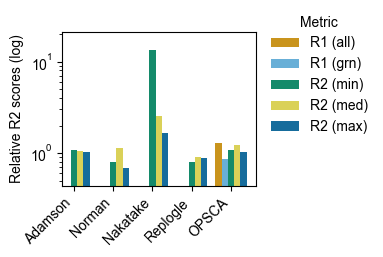

In [82]:
def plot_tf_maked_versus_correlation(ax):
    scores_mat_n_all_long = scores_mat_n_all.reset_index().melt(id_vars='index')
    scores_mat_n_all_long['index'] = scores_mat_n_all_long['index'].map(surragate_names)

    scores_mat_n_all_long.variable = scores_mat_n_all_long.variable.astype(metrics_category_order)
    sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Relative R2 scores (log)')
    ax.set_yscale('log')

    # Adjust margins and layout for the plot
    ax.margins(x=0.05)
    ax.margins(y=0.15)
    # for side in ['right', 'top']:
    #     ax.spines[side].set_visible(False)
    ax.legend(title="Metric", loc=(1.05, .3), frameon=False)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2), sharey=False)
plot_tf_maked_versus_correlation(ax)
fig.savefig(f"{results_folder}/figs/tf_guided_barplot.png", dpi=300, transparent=True, bbox_inches='tight')

# Combined plots

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/4285641663.py:17: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(scores_mat_n_all_long, x='index', y='value', hue='variable', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/4285641663.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3360922109.py:21: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(data=df_melted, x='index', y='Normalized Score', hue='Method', marker='o', ax=ax, palette=colors_blind)
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/29064988.py:14: UserWarning: The palette list has more values (7) than needed (

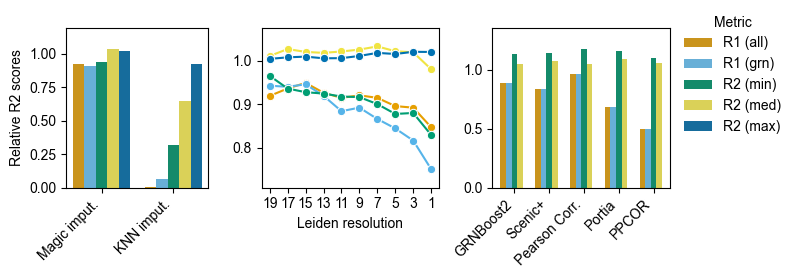

In [83]:
fig = plt.figure(figsize=(8, 2.7))

# Define the gridspec with uneven ratios for rows and columns
gs = fig.add_gridspec(1, 3, width_ratios=[.8, 1, 1])
i=0
ax = fig.add_subplot(gs[0, i]) 
plot_imput_vs_singlecell(ax)
ax.get_legend().remove()
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_line_pseudobulking_effect(ax)
ax.get_legend().remove()
ax.set_ylabel('')
i+=1

ax = fig.add_subplot(gs[0, i]) 
plot_gb_vs_ridge(ax)
# ax.get_legend().remove()
ax.set_ylabel('')
# ax.set_yticklabels([])
i+=1

# ax = fig.add_subplot(gs[0, i]) 
# plot_tf_maked_versus_correlation(ax)
# # ax.get_legend().remove()
# ax.set_ylabel('Relative R2 score (log)')
# ax.set_title('TF-guided vs pure correction', pad=15)
# i+=1
# for side in ['right', 'top']:
#         ax.spines[side].set_visible(True)

# fig.subplots_adjust(left=0.1, right=0.9)  # Set global boundaries if needed
# ax_list = fig.axes  # List of all axes

# # Leftmost axis
# ax_list[0].set_position([0.05, 0.2, 0.2, 0.6])  # Farther left
# # First middle axis
# ax_list[1].set_position([0.34, 0.2, 0.2, 0.6])  # Closer to the second middle axis
# # Second middle axis
# ax_list[2].set_position([0.56, 0.2, 0.2, 0.6])  # Closer to the first middle axis
# # Rightmost axis
# ax_list[3].set_position([0.84, 0.2, 0.2, 0.6])  # Farther right
plt.tight_layout()
fig.savefig(f"{results_folder}/figs/relative_scores_all.png", dpi=300, transparent=True, bbox_inches='tight')

# Robustness analysis

In [84]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

In [85]:
base_dir = '../../task_grn_inference/resources/results/robustness_analysis'
figsize=(3.5, 3)

noise_type = 'net'
reg1_mat_net, reg2_mat_net = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'sign'
reg1_mat_sign, reg2_mat_sign = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'weight'
reg1_mat_weight, reg2_mat_weight = format_robustness_results(base_dir, noise_type=noise_type)
noise_type = 'direction'
reg1_mat_direction, reg2_mat_direction = format_robustness_results(base_dir, noise_type=noise_type)

In [86]:
def merge_df(reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction):
    reg_mat_net['Permute type'] = 'TF-gene connections'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene weight'
    reg_mat_direction['Permute type'] = 'TF-gene direction'
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction])
    df_concat = df_concat.drop(columns=['negative_control'])
    #  'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))
    df_concat.reset_index().rename(columns={'index':'degree'}).melt(id_vars=['Permute type', 'degree'], var_name='model',value_name='r2score')
    df_concat = df_concat[~((df_concat['Permute type'] == 'TF-gene sign')&(df_concat.index == 100))]

    df_concat.columns.map(lambda name: surragate_names.get(name, name))

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_concat = df_concat.melt(id_vars=['Permute type', 'Degree'], var_name='model', value_name='r2score')


    
    # df_concat['model'] = df_concat['model'].astype(category_order)
    return df_concat


df_reg1 = merge_df(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, reg1_mat_direction)
df_reg2 = merge_df(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, reg2_mat_direction)


In [87]:
# df_reg1

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_stacked_bar(df_all, ax, col='TF-gene connections'):
    
    def normalize(df):
        df = df.set_index('Degree')
        df['share'] = 0
        baseline = df.loc[0, 'r2score']
        for i, degree in enumerate(df.index):

            if degree == 0:
                share = 0
            else:
                share = 100*np.abs(df.loc[degree, 'r2score'] - baseline)/baseline
                df.loc[degree, 'share'] = share - previous_degree
                
            previous_degree = share
        
        return df
    df_all = df_all.groupby(['Permute type', 'model']).apply(normalize).reset_index(level='Degree').drop(columns='r2score')
    df_all['Degree'] = df_all['Degree'].astype('category')
    
    df = df_all[df_all['Permute type'] == col].drop(columns='Permute type')

    df.pivot(index='model', columns='Degree', values='share').plot(kind='bar', stacked=True,  ax=ax, color=colors_cell_type)

    ax.get_legend().remove()
    ax.set_ylabel("R² score decline (%)")
    ax.set_xlabel("")
    ax.set_title(col, pad=12)
    ax.tick_params('x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')  # Set horizontal alignment to 'left'
        # plt.title("Drop in R² Score by Degree for Each Model")
    legend = ax.legend(title="Permutation\n   intensity", bbox_to_anchor=(1.05, 1), frameon=False)

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3261356239.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.278490969368843' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[degree, 'share'] = share - previous_degree
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3261356239.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.899025060686595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[degree, 'share'] = share - previous_degree
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3261356239.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.112217187464312' has dtype incompatible with 

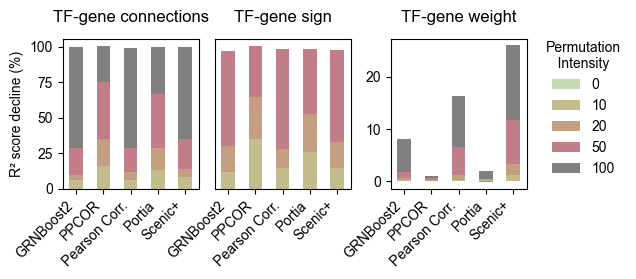

In [89]:
fig = plt.figure(figsize=(8, 2))

# Define the gridspec with uneven ratios for rows and columns
gs = fig.add_gridspec(1, 4)
df_reg1_short = df_reg1[df_reg1['model'].isin(['GRNBoost2', 'Scenic+', 'Pearson Corr.', 'Portia', 'PPCOR'])]

ax = fig.add_subplot(gs[0, 0]) 
plot_stacked_bar(df_reg1_short, ax, col='TF-gene connections')
ax.get_legend().remove()

ax = fig.add_subplot(gs[0, 1]) 
plot_stacked_bar(df_reg1_short, ax, col='TF-gene sign')
ax.set_ylabel('')
ax.set_yticks([])
ax.get_legend().remove()


ax = fig.add_subplot(gs[0, 2]) 
plot_stacked_bar(df_reg1_short, ax, col='TF-gene weight')
ax.set_ylabel('')
ax.get_legend().remove()
legend = ax.legend(title="Permutation\n   Intensity", loc=(1.1, .05), frameon=False)



# Adjust positions for subplots in 2 rows
ax_list = fig.axes  # List of all axes

ax_list[0].set_position([0.01, 0.1, 0.17, 0.75])  
ax_list[1].set_position([0.2, 0.1, 0.17, 0.75])  
ax_list[2].set_position([0.42, 0.1, 0.17, 0.75]) 

fig.savefig(f"{results_folder}/figs/robustnes_analysis_reg1_1.png", dpi=300, transparent=True, bbox_inches='tight') 

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3261356239.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.2051378584155055' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[degree, 'share'] = share - previous_degree
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3261356239.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0322668045458292' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[degree, 'share'] = share - previous_degree
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/3261356239.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.747414331468909' has dtype incompatible with

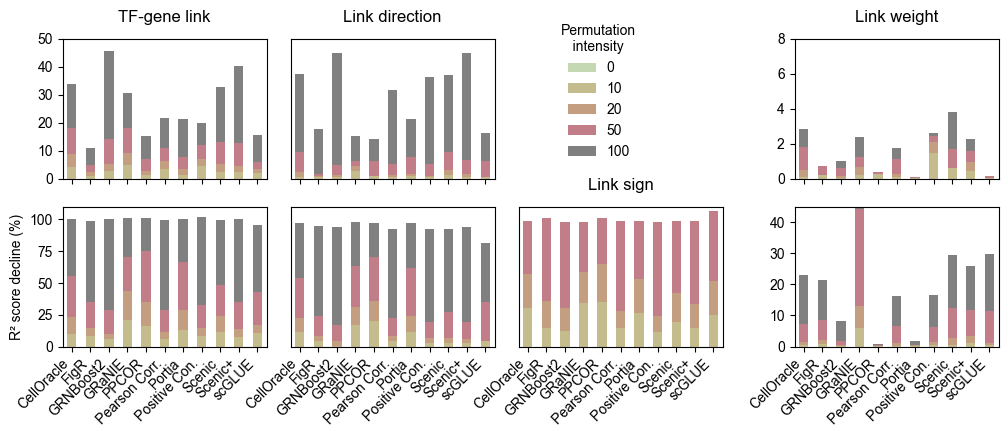

In [90]:
fig = plt.figure(figsize=(12, 4))

# Define the gridspec with uneven ratios for rows and columns
gs = fig.add_gridspec(2, 4)

ax = fig.add_subplot(gs[0, 0]) 
plot_stacked_bar(df_reg2, ax, col='TF-gene connections')
ax.set_xticklabels([])
ax.get_legend().remove()
ax.set_ylim([0,50])
ax.set_ylabel('')
ax.set_title('TF-gene link', pad=12)
ax = fig.add_subplot(gs[1, 0]) 
plot_stacked_bar(df_reg1, ax, col= 'TF-gene connections')
ax.set_title('')
ax.get_legend().remove()
ax.set_ylim([0,110])


ax = fig.add_subplot(gs[0, 1]) 
plot_stacked_bar(df_reg2, ax, col='TF-gene direction')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_ylim([0,52])
ax.set_title('Link direction', pad=12)
legend = ax.legend(title="Permutation\n   intensity", loc=(1.3, .1), frameon=False)
ax = fig.add_subplot(gs[1, 1]) 
plot_stacked_bar(df_reg1, ax, col= 'TF-gene direction')
ax.set_ylabel('')
ax.set_title('')
ax.get_legend().remove()
ax.set_ylim([0,112])
ax.set_yticks([])


ax = fig.add_subplot(gs[1, 2]) 
plot_stacked_bar(df_reg1, ax, col= 'TF-gene sign')
ax.set_ylabel('')
ax.set_title('Link sign', pad=12)
ax.get_legend().remove()
ax.set_yticks([])
ax.set_ylim([0,112])

ax = fig.add_subplot(gs[0, 3]) 
plot_stacked_bar(df_reg2, ax, col='TF-gene weight')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_title('Link weight', pad=12)

ax.set_ylim([0,8])
ax.get_legend().remove()
ax = fig.add_subplot(gs[1, 3]) 
plot_stacked_bar(df_reg1, ax, col= 'TF-gene weight')
ax.set_ylabel('')
ax.set_title('')
ax.get_legend().remove()
ax.set_ylim([0,45])


# Adjust positions for subplots in 2 rows
ax_list = fig.axes  # List of all axes

ax_list[0].set_position([0.01, 0.52, 0.17, 0.35])  
ax_list[1].set_position([0.01, 0.1, 0.17, 0.35]) 
ax_list[2].set_position([0.2, 0.52, 0.17, 0.35])  
ax_list[3].set_position([0.2, 0.1, 0.17, 0.35]) 
ax_list[4].set_position([0.39, 0.1, 0.17, 0.35]) 


ax_list[5].set_position([0.62, 0.52, 0.17, 0.35])  
ax_list[6].set_position([0.62, 0.1, 0.17, 0.35]) 

fig.savefig(f"{results_folder}/figs/robustnes_analysis.png", dpi=300, transparent=True, bbox_inches='tight') 

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/2236419591.py:39: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/2236419591.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/2236419591.py:39: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_44380/2236419591.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel

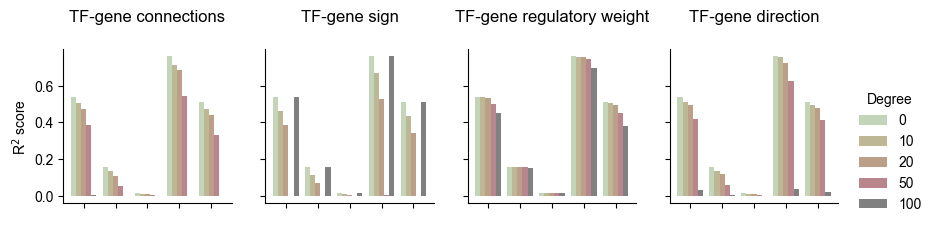

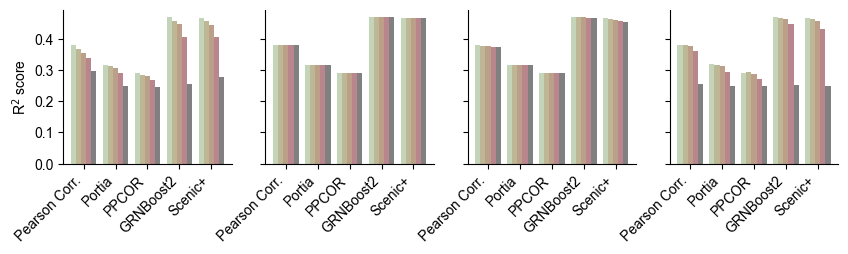

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_robustness(reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction, axes):
    reg_mat_net['Permute type'] = 'TF-gene connections'
    reg_mat_sign['Permute type'] = 'TF-gene sign'
    reg_mat_weight['Permute type'] = 'TF-gene regulatory weight'
    reg_mat_direction['Permute type'] = 'TF-gene direction'

    # Concatenate the DataFrames
    df_concat = pd.concat([reg_mat_net, reg_mat_sign, reg_mat_weight, reg_mat_direction])
    df_concat = df_concat.drop(columns=['negative_control', 'scglue', 'granie', 'positive_control', 'celloracle', 'scenic', 'figr'])
    
    df_concat.columns = df_concat.columns.map(lambda name: surragate_names.get(name, name))

    # Reset the index so that noise degree remains a column
    df_concat.reset_index(inplace=True, drop=False)
    df_concat.rename(columns={'index': 'Degree'}, inplace=True)

    df_melt = pd.melt(df_concat, id_vars=['Degree', 'Permute type'], 
                    var_name='method', value_name=r'R$^2$ score')

    df_melt = df_melt[df_melt.method != 'Degree']

    # Create subplots for each 'Permute type'
    permute_types = df_melt['Permute type'].unique()
    

    if len(permute_types) == 1:
        axes = [axes]  # Ensure axes is always a list even if there's only one subplot

    for i, permute_type in enumerate(permute_types):
        ax = axes[i]
        # Filter data for the current 'Permute type'
        subset = df_melt[df_melt['Permute type'] == permute_type]

        # Create a bar plot for each subset
        sns.barplot(
            data=subset, 
            x='method', 
            y=r'R$^2$ score', 
            hue='Degree', 
            ax=ax, 
            palette=colors_cell_type
        )

        # Rotate the x-axis labels and remove x-label
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')

        # Set the title for each subplot
        # ax.set_title(f'({chr(97 + i)}) {permute_type}', fontsize=12, pad=20)
        ax.set_title(f'{permute_type}', fontsize=12, pad=20)

        # Adjust margins and layout for the plot
        ax.margins(x=0.05)
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.get_legend().remove()

    # Move the legend outside

    # plt.tight_layout()
    # plt.subplots_adjust(top=0.85)  # Adjust the top space for the suptitle
fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
# Example usage:
plot_robustness(reg1_mat_net, reg1_mat_sign, reg1_mat_weight, reg1_mat_direction, axes)
# plt.suptitle('Permutation analysis, Regression 1', y=1.1, fontsize=14, fontweight='bold')
for ax in axes:
    ax.set_xticklabels([])
plt.legend(title="Degree", bbox_to_anchor=(1.05, .8), loc='upper left', frameon=False)


plt.savefig(f"{results_folder}/figs/robustness_reg1.png", dpi=300, transparent=True, bbox_inches='tight')
fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
plot_robustness(reg2_mat_net, reg2_mat_sign, reg2_mat_weight, reg2_mat_direction, axes)
# plt.suptitle('Permutation analysis, Regression 2', y=1.1, fontsize=14, fontweight='bold')
for ax in axes:
    ax.set_title('')
# plt.subplots_adjust(
#     left=0.1,  # Space from the left edge of the figure
#     right=0.95,  # Space from the right edge of the figure
#     top=0.9,  # Space from the top of the figure
#     bottom=0.1,  # Space from the bottom of the figure
#     hspace=0.3,  # Height (vertical) space between rows
#     wspace=.3   # Width (horizontal) space between columns
# )

plt.savefig(f"{results_folder}/figs/robustness_reg2.png", dpi=300, transparent=True, bbox_inches='tight')